<a href="https://colab.research.google.com/github/METIS-DATA-SCIENCE-PROJECTS/Yelp_Recommender_System/blob/main/YELP_Recommender_SPARK_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget --load-cookies -q https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz.2
!pip install -q findspark

Cannot open cookies file ‘-q’: No such file or directory
--2022-04-21 00:51:48--  https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300971569 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop3.2.tgz’

spark-3.2.1-bin-had 100%[===================>] 287.03M  23.2MB/s    in 13s     

2022-04-21 00:52:02 (22.2 MB/s) - ‘spark-3.2.1-bin-hadoop3.2.tgz’ saved [300971569/300971569]

tar: spark-3.2.1-bin-hadoop3.2.tgz.2: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [3]:
!pip install pyspark py4j

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 199 kB 45.6 MB/s 
     |████████████████████████████████| 198 kB 46.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=96759fb130504f42fd00fc6be782d880d39085cf0ee02e161bb3cc63143d0f65
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
!pip install pyspark

In [5]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
warnings.filterwarnings('ignore')
import pyspark
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import udf
SparkSession.builder.config(conf=SparkConf())


%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [6]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# **EDA** & **DATA CLEANING**

In [7]:
df_review = spark.read.json("/content/drive/MyDrive/sparkdata/yelp_academic_dataset_review.json")
df_review.printSchema()
df_review.show()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [8]:
df_review.createOrReplaceTempView('review')
review_counts = spark.sql(r"""SELECT stars, COUNT(stars) AS total FROM review GROUP BY stars""")
review_counts.show()
print((df_review.count(), len(df_review.columns)))

+-----+-------+
|stars|  total|
+-----+-------+
|  1.0|1069561|
|  4.0|1452918|
|  3.0| 691934|
|  2.0| 544240|
|  5.0|3231627|
+-----+-------+

(6990280, 9)


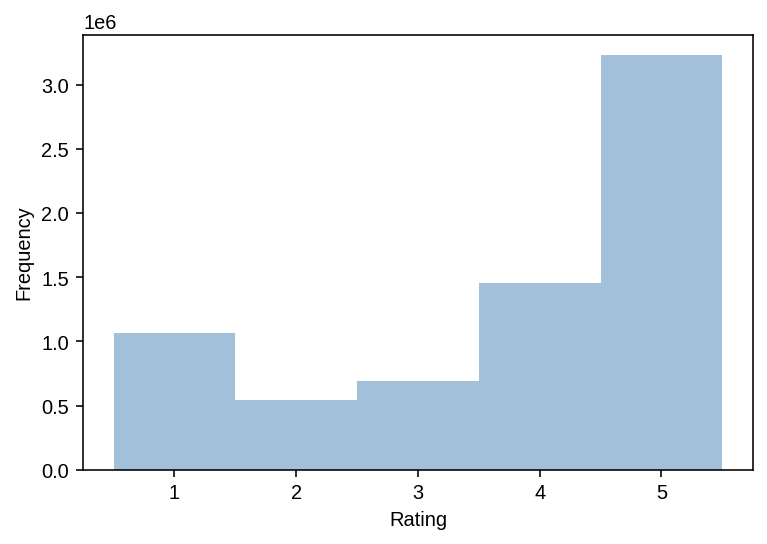

In [9]:
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [10]:
df_business = spark.read.json("/content/drive/MyDrive/sparkdata/yelp_academic_dataset_business.json")
df_business.printSchema()
df_business.show()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [11]:
df_business.createOrReplaceTempView('business')
state_counts = spark.sql(r"""SELECT state, COUNT(state) AS total FROM business GROUP BY state order by total desc""")
state_counts.show()

+-----+-----+
|state|total|
+-----+-----+
|   PA|34039|
|   FL|26330|
|   TN|12056|
|   IN|11247|
|   MO|10913|
|   LA| 9924|
|   AZ| 9912|
|   NJ| 8536|
|   NV| 7715|
|   AB| 5573|
|   CA| 5203|
|   ID| 4467|
|   DE| 2265|
|   IL| 2145|
|   TX|    4|
|   CO|    3|
|   MA|    2|
|   WA|    2|
|   HI|    2|
|   MI|    1|
+-----+-----+
only showing top 20 rows



In [12]:
city = spark.sql(r"""SELECT city, COUNT(city) AS total FROM business GROUP BY city order by total desc""")
city.show()

+----------------+-----+
|            city|total|
+----------------+-----+
|    Philadelphia|14569|
|          Tucson| 9250|
|           Tampa| 9050|
|    Indianapolis| 7540|
|       Nashville| 6971|
|     New Orleans| 6209|
|            Reno| 5935|
|        Edmonton| 5054|
|     Saint Louis| 4827|
|   Santa Barbara| 3829|
|           Boise| 2937|
|      Clearwater| 2221|
|Saint Petersburg| 1663|
|        Metairie| 1643|
|          Sparks| 1624|
|      Wilmington| 1446|
|        Franklin| 1414|
|       St. Louis| 1255|
|  St. Petersburg| 1185|
|        Meridian| 1043|
+----------------+-----+
only showing top 20 rows



In [13]:
#0 = closed, 1 =open
is_open = spark.sql(r"""SELECT is_open, COUNT(is_open) AS total FROM business GROUP BY is_open order by total desc""")
is_open.show()

+-------+------+
|is_open| total|
+-------+------+
|      1|119698|
|      0| 30648|
+-------+------+



In [14]:

df_business_open = df_business.filter((df_business.is_open == 1) & (df_business.city=="Philadelphia"))
df_business_open.show()

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|         935 Race St|{null, null, u'no...|MTSW4McQd7CbVtyjq...|Restaurants, Food...|Philadelphia|{7:0-21:0, 7:0-20...|      1|   39.9555052|   -75.1555641|  St Honore Pastries|      19107|          80|  4.0|   PA|
|         205 Race St|{null, null, 'ful...|MUTTqe8uqyMdBl186...|Sushi Bars, Resta...|Philadelphia|{13:30-23:0, null...|      1|    39.953949

In [15]:
df_business_open.createOrReplaceTempView('business_open')
business_open=spark.sql(r"""SELECT is_open, COUNT(is_open) AS total FROM business_open GROUP BY is_open order by total desc""")
business_open.show()

+-------+-----+
|is_open|total|
+-------+-----+
|      1|10542|
+-------+-----+



In [16]:
df_business_open.show()
print((df_business_open.count(), len(df_business_open.columns)))

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|         935 Race St|{null, null, u'no...|MTSW4McQd7CbVtyjq...|Restaurants, Food...|Philadelphia|{7:0-21:0, 7:0-20...|      1|   39.9555052|   -75.1555641|  St Honore Pastries|      19107|          80|  4.0|   PA|
|         205 Race St|{null, null, 'ful...|MUTTqe8uqyMdBl186...|Sushi Bars, Resta...|Philadelphia|{13:30-23:0, null...|      1|    39.953949

In [17]:
spark.sql(r"""SELECT categories, COUNT(business_id) AS total FROM business_open GROUP BY categories order by total desc""").show()

+--------------------+-----+
|          categories|total|
+--------------------+-----+
|  Restaurants, Pizza|  109|
|  Pizza, Restaurants|   77|
|Nail Salons, Beau...|   74|
|Beauty & Spas, Na...|   64|
|Beauty & Spas, Ha...|   64|
|Hair Salons, Beau...|   62|
|Chinese, Restaurants|   61|
|Restaurants, Chinese|   60|
|  Food, Coffee & Tea|   33|
|Automotive, Auto ...|   31|
|Food, Beer, Wine ...|   28|
|Auto Repair, Auto...|   28|
|Banks & Credit Un...|   28|
|  Coffee & Tea, Food|   27|
|Restaurants, Mexican|   26|
|Barbers, Beauty &...|   25|
| Automotive, Parking|   22|
| Parking, Automotive|   21|
|Beer, Wine & Spir...|   21|
|Hotels & Travel, ...|   20|
+--------------------+-----+
only showing top 20 rows



In [18]:
import re
from pyspark.sql.functions import sum, col, desc

df_business_clean = df_business_open.filter(df_business_open.categories.like('%Breakfast%') | df_business_open.categories.like('%Food%') |
                       df_business_open.categories.like( '%Restaurants%') | df_business_open.categories.like('%Bars%') |
                        df_business_open.categories.like('%Sandwiches%') | df_business_open.categories.like('%Coffee%'))

df_business_clean.show()


+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|         935 Race St|{null, null, u'no...|MTSW4McQd7CbVtyjq...|Restaurants, Food...|Philadelphia|{7:0-21:0, 7:0-20...|      1|   39.9555052|   -75.1555641|  St Honore Pastries|      19107|          80|  4.0|   PA|
|         205 Race St|{null, null, 'ful...|MUTTqe8uqyMdBl186...|Sushi Bars, Resta...|Philadelphia|{13:30-23:0, null...|      1|    39.953949

In [19]:
print(df_business_clean.tail(2))

[Row(address='6024 Ridge Ave', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="u'none'", Ambience="{'touristy': None, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='True', GoodForMeal="{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}", HairSpecializesIn=None, HappyHour=None, HasTV='True', Music=None, NoiseLevel="u'average'", Open24Hours=None, OutdoorSeating='False', RestaurantsAttire="u'casual'", RestaurantsCounterService=None, Res

In [20]:
print((df_business_clean.count(), len(df_business_clean.columns)))

(4565, 14)


In [21]:
# # Function that extract keys from the nested dictionary
# def extract_keys(attr, key):
#     if attr == None:
#         return "{}"
#     if key in attr:
#         return attr.pop(key)

# # convert string to dictionary
# import ast
# def str_to_dict(attr):
#     if attr != None:
#         return ast.literal_eval(attr)
#     else:
#         return ast.literal_eval("{}")

In [22]:
# import pyspark.sql.functions as f

# extractUDF = f.udf(lambda z: extract_keys(z)) 
# strtodictUDF = f.udf(lambda z: str_to_dict(z)) 

In [23]:
# # get dummies from nested attributes
# df_business_clean = df_business_clean.withColumn('BusinessParking', strtodictUDF(extractUDF(f.col("attributes"))))
# #df_business_clean = df_business_clean.select(col("BusinessParking"), strtodictUDF(extractUDF(df_business_clean.col("attributes"))).alias("attributes"))

# # df_business_clean['BusinessParking'] = df_business_clean.apply(lambda x: strtodictUDF(extractUDF(x['attributes'], 'BusinessParking')), axis=1)
# # df_business_clean['Ambience'] = df_business_clean.apply(lambda x: strtodictUDF(extractUDF(x['attributes'], 'Ambience')), axis=1)
# # df_business_clean['GoodForMeal'] = df_business_clean.apply(lambda x: strtodictUDF(extractUDF(x['attributes'], 'GoodForMeal')), axis=1)
# # df_business_clean['Dietary'] = df_business_clean.apply(lambda x: strtodictUDF(extractUDF(x['attributes'], 'Dietary')), axis=1)
# # df_business_clean['Music'] = df_business_clean.apply(lambda x: strtodictUDF(extractUDF(x['attributes'], 'Music')), axis=1)

In [24]:
df_user = spark.read.json("/content/drive/MyDrive/sparkdata/yelp_academic_dataset_user.json")
df_user.printSchema()
df_user.show()

print((df_user.count(), len(df_user.columns)))

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

+-------------+---------------+---------------+----------------+-----

In [25]:
df_user.createOrReplaceTempView('user')
user_counts = spark.sql(r"""SELECT user_id,fans,average_stars,yelping_since,review_count \
FROM user GROUP BY user_id,average_stars,fans,yelping_since,review_count order by review_count desc""")
user_counts.show()

+--------------------+----+-------------+-------------------+------------+
|             user_id|fans|average_stars|      yelping_since|review_count|
+--------------------+----+-------------+-------------------+------------+
|Hi10sGSZNxQH3NLyW...|3493|         3.77|2009-05-26 11:33:58|       17473|
|8k3aO-mPeyhbR5HUu...|1462|         3.35|2007-12-08 14:56:45|       16978|
|hWDybu_KvYLSdEFzG...| 867|         3.67|2009-03-08 21:47:44|       16567|
|RtGqdDBvvBCjcu5dU...| 300|         3.87|2010-10-17 06:35:06|       12868|
|P5bUL3Engv-2z6kKo...| 825|         3.81|2006-05-31 21:27:42|        9941|
|nmdkHL2JKFx55T3nq...| 921|         3.75|2011-11-29 15:50:53|        8363|
|bQCHF5rn5lMI9c5kE...| 362|         3.87|2012-03-18 10:04:51|        8354|
|8RcEwGrFIgkt9WQ35...| 288|         3.49|2009-11-06 22:53:16|        7738|
|Xwnf20FKuikiHcSpc...| 285|         3.32|2011-06-10 03:52:07|        6766|
|CxDOIDnH8gp9KXzpB...| 828|         3.34|2009-11-09 20:44:45|        6679|
|IucvvxdQXXhjQ4z6O...| 18

In [26]:
df_checkin = spark.read.json("/content/drive/MyDrive/sparkdata/yelp_academic_dataset_checkin.json")
df_checkin.printSchema()
df_checkin.show()
print((df_checkin.count(), len(df_checkin.columns)))

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
|--8IbOsAAxjKRoYsB...|2015-06-06 01:03:...|
|--9osgUCSDUWUkoTL...|2015-06-13 02:00:...|
|--ARBQr1WMsTWiwOK...|2014-12-12 00:44:...|
|--FWWsIwxRwuw9vIM...|2010-09-11 16:28:...|
|--FcbSxK1AoEtEAxO...|2017-08-18 19:43:...|
|--LC8cIrALInl2vyo...|2017-01-12 19:10:...|
|--MbOh2O1pATkXa7x...|2013-04-21 01:52:...|
|--N9yp3ZWqQIm7DqK...|2012-10-06 20:46:...|
|--O3ip9NpXTKD4oBS...|2010-04-17 21:07:...|
|--OS_I7dnABrXvRCC...| 2018-05-11 18:23:36|
|--S43ruInmIsGrnnk...|2010-08-29 01:17:...|
|--SJXpAa0E-GCp2sm...|2014-04-06 22:23:...|
|--Sd93OFWITqDHifM...|2013-01-09 17

In [27]:
df_checkin.createOrReplaceTempView('checkin')
checkin_counts = spark.sql(r"""SELECT business_id, COUNT(business_id) AS total FROM checkin GROUP BY business_id order by total desc""")
checkin_counts.show()

+--------------------+-----+
|         business_id|total|
+--------------------+-----+
|-0iIxySkp97WNlwK6...|    1|
|-1dARtemb2Gy7Xlft...|    1|
|-BB9Xn-ak_23FxVEW...|    1|
|-JAwNIEJoDXmdE_8s...|    1|
|-UADx0eR5Huq6s1CP...|    1|
|-WUHfRZ7a5NQA4TyG...|    1|
|-WvUB8bDBNXuvTU9i...|    1|
|-ZzCVD9Ge7KCy4ffh...|    1|
|-ajaASaDA_77I6pK3...|    1|
|-dB0vYhiTeBDlayTz...|    1|
|-f5A6KKUu4jZN1qpt...|    1|
|-fjIX9bvBKwXjQWfd...|    1|
|-mxgEmVaB0Izs2-qa...|    1|
|-nEqIKUP2ykB7rSIh...|    1|
|-rKaikuKBl1BwDPNJ...|    1|
|04Itzpsew47i9UJ3u...|    1|
|05qVGl0KbrzU9gbTp...|    1|
|07uojIeVeauFxa7yO...|    1|
|0Y8xQvpbmO02SsFZt...|    1|
|0jgz7W-ytCK-LmN84...|    1|
+--------------------+-----+
only showing top 20 rows



In [28]:
df_tip = spark.read.json("/content/drive/MyDrive/sparkdata/yelp_academic_dataset_tip.json")
df_tip.printSchema()
df_tip.show()
print((df_tip.count(), len(df_tip.columns)))

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|3uLgwr0qeCNMjKenH...|               0|2012-05-18 02:17:21|Avengers time wit...|AGNUgVwnZUey3gcPC...|
|QoezRbYQncpRqyrLH...|               0|2013-02-05 18:35:10|They have lots of...|NBN4MgHP9D3cw--Sn...|
|MYoRNLb5chwjQe3c_...|               0|2013-08-18 00:56:08|It's open even wh...|-copOvldyKh1qr-vz...|
|hV-bABTK-glh5wj31...|               0|2017-06-27 23:05:38|Very decent fried...|FjMQVZjSqY8syIO-5...|
|_uN0OudeJ3Zl_tf6n...|               0|2012-10-06 19:43:09|Appetizers.. plat...|

In [29]:
df_tip.createOrReplaceTempView('tip')
tip_counts = spark.sql(r"""SELECT business_id,date, COUNT(compliment_count) AS total FROM tip GROUP BY business_id,date order by total desc""")
tip_counts.show()

+--------------------+-------------------+-----+
|         business_id|               date|total|
+--------------------+-------------------+-----+
|06PmqoU3uY5Vb-BEa...|2014-02-20 04:09:37|    6|
|WltG6PWu0zRTTUpWn...|2014-04-02 02:41:58|    4|
|x2sLTY57QFvlfmt55...|2012-04-12 02:29:40|    3|
|FX-jvdASfxUqTMbjD...|2017-06-08 20:41:26|    3|
|wJAK6B-dmgGrco3KY...|2014-05-07 21:05:38|    3|
|2JEzWTF9tazzjyzCT...|2017-09-27 18:29:38|    2|
|U4yrxSpqLaPrGqcqo...|2012-07-21 03:46:07|    2|
|ypetvi7gxJHP-32EL...|2012-07-27 17:26:35|    2|
|sk2lZI4zmuGAccd3D...|2012-06-21 12:59:12|    2|
|pWuoHHu0LuVrD0Hja...|2016-09-05 03:09:10|    2|
|PVRs2-0uQYqfdhoCi...|2017-08-02 00:22:58|    2|
|-QI8Qi8XWH3D8y8et...|2017-10-17 13:19:33|    2|
|qY-BUQY-SFBaSrFHo...|2016-01-01 19:35:05|    2|
|TebJaTyTkScemRVHZ...|2015-04-04 17:34:29|    2|
|D9p7-HsY9llYP3BaC...|2017-06-23 00:08:09|    2|
|diovHdArxKlT5ZgkT...|2017-04-01 23:52:40|    2|
|XFchuplA5RvxA4Da2...|2011-07-06 20:01:41|    2|
|yZHiutcbym-xLGkmF..

In [30]:
df_review.cache()
df_user.cache()

DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string]

In [31]:
assert df_review.is_cached
assert df_user.is_cached

###Table Joins

In [32]:
# Joining user and review tables
df_review.registerTempTable('df_review')
df_business_clean.registerTempTable('df_business_clean')

# join using SQL
df_user_and_business = spark.sql(r"""SELECT df_business_clean.business_id, attributes, categories,city,is_open,name,review_count, df_business_clean.stars,
                            df_review.user_id,df_review.text
                                   FROM df_business_clean 
                                   LEFT JOIN df_review
                                   ON df_business_clean.business_id = df_review.business_id""")
df_user_and_business.show()

print((df_user_and_business.count(), len(df_user_and_business.columns)))

+--------------------+--------------------+--------------------+------------+-------+------------------+------------+-----+--------------------+--------------------+
|         business_id|          attributes|          categories|        city|is_open|              name|review_count|stars|             user_id|                text|
+--------------------+--------------------+--------------------+------------+-------+------------------+------------+-----+--------------------+--------------------+
|FTFtoylMzkrzqNVSl...|{null, null, null...|       Grocery, Food|Philadelphia|      1| Giant Food Stores|          19|  4.0|B_SBNlvZ46mzV4c6y...|It's so nice to h...|
|FTFtoylMzkrzqNVSl...|{null, null, null...|       Grocery, Food|Philadelphia|      1| Giant Food Stores|          19|  4.0|gHUJQESZY_UESjTxh...|Not great, but no...|
|FTFtoylMzkrzqNVSl...|{null, null, null...|       Grocery, Food|Philadelphia|      1| Giant Food Stores|          19|  4.0|fKjixK95mQzLP59OS...|The new Giant is ...|
|FTF

##Sentiment of the joined table categories

In [33]:
restaurant_categories = df_user_and_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

In [34]:
text = " ".join(review for review in restaurant_categories_list)

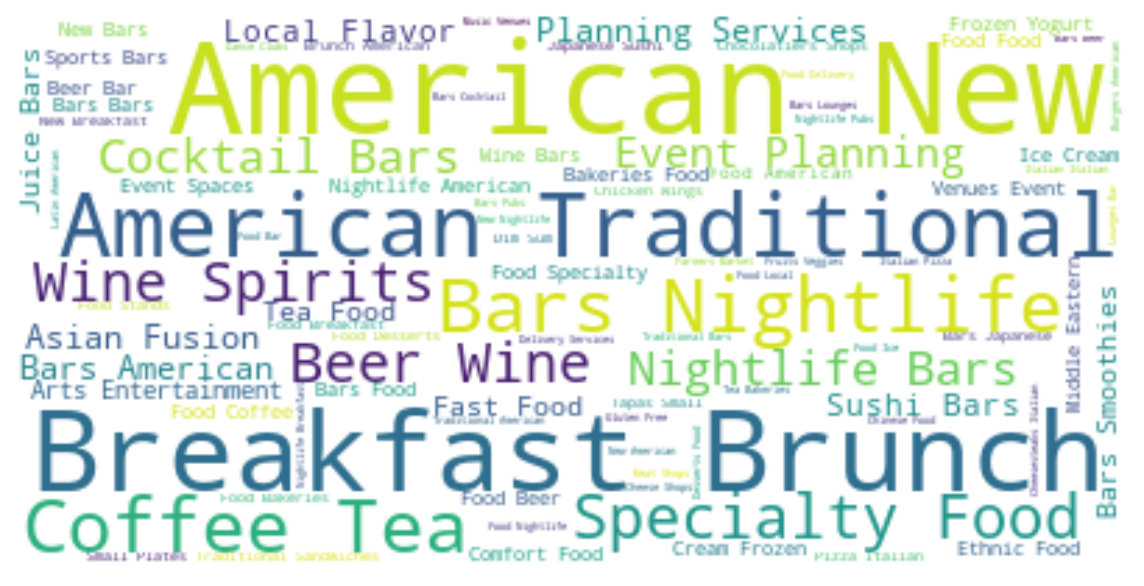

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Splitting the categories

In [36]:
#splitting the restaurant categories
from pyspark.sql.functions import col, split

split_col =  split(df_user_and_business.categories, ',')
df_new = df_user_and_business.withColumn('col1', split_col.getItem(0)) \
       .withColumn('col2', split_col.getItem(1)) \
       .withColumn('col3', split_col.getItem(2)) \
       .withColumn('col4', split_col.getItem(3))

df_new.show(truncate=False)
print((df_new.count(), len(df_new.columns)))

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------+------------+-------+------------------+------------+-----+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
#Analyzing each separate category for the newly created sub-category columns
df_new.groupBy("col1").count().orderBy(desc('count')).show(30)
df_new.groupBy("col2").count().orderBy(desc('count')).show(30)
df_new.groupBy("col3").count().orderBy(desc('count')).show(30)
df_new.groupBy("col4").count().orderBy(desc('count')).show(30)

+--------------------+------+
|                col1| count|
+--------------------+------+
|         Restaurants|122681|
|                Food| 38465|
|           Nightlife| 31509|
|          Sandwiches| 21980|
|                Bars| 20835|
|  Breakfast & Brunch| 18517|
|             Italian| 15191|
|American (Traditi...| 13244|
|               Pizza| 12398|
|      American (New)| 11161|
|        Coffee & Tea| 10107|
|            Japanese|  9791|
|             Mexican|  8687|
|             Chinese|  8358|
|             Lounges|  7011|
|             Seafood|  6874|
|                Beer|  5983|
|             Burgers|  5885|
|                Thai|  5848|
|        Candy Stores|  5797|
|          Sushi Bars|  5581|
|            Bakeries|  5492|
|      Specialty Food|  5481|
|       Mediterranean|  5270|
|Event Planning & ...|  5245|
|       Cocktail Bars|  5181|
|Ice Cream & Froze...|  5135|
|               Cafes|  4445|
|        Cheesesteaks|  4333|
|      Latin American|  4052|
+---------

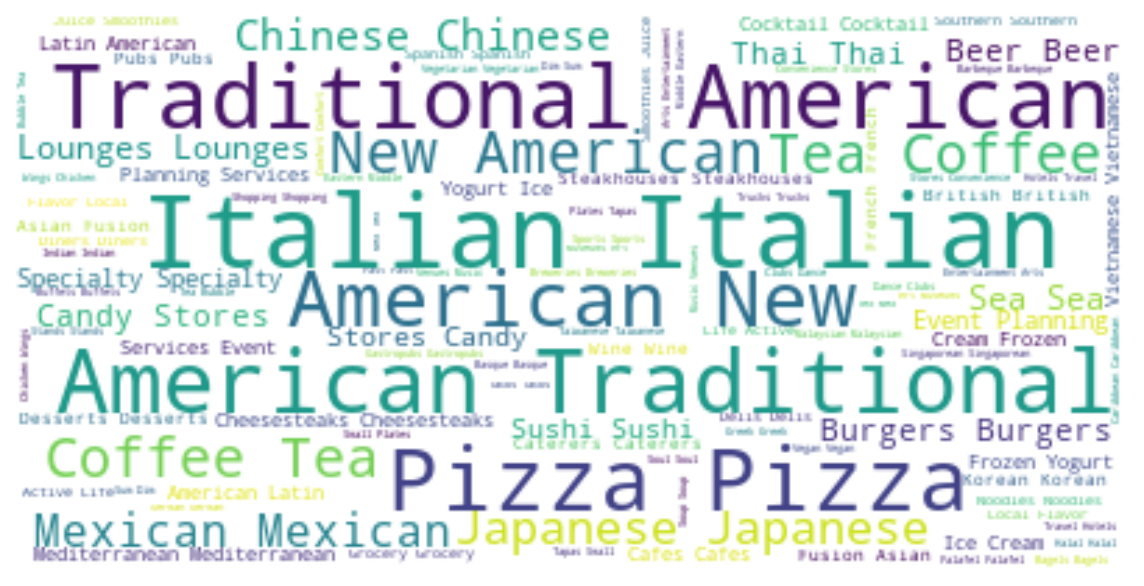

In [38]:
#Generating sentiment for the first col1
col1_categories = df_new.select('col1').collect()
col1_categories_list = [col1_categories[i][0] for i in range(len(col1_categories))]

text = " ".join(review for review in col1_categories_list)

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('Bars', "")
text = text.replace('food', "")
text = text.replace('Food', "")
text = text.replace('Brunch', "")
text = text.replace('Breakfast', "")
text = text.replace('Bakeries', "")
text = text.replace('Sandwiches', "")
text = text.replace('Salad', "")
text = text.replace('Nightlife', "")

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
# creating the dataframe with the select columns
df_final = df_new.select("business_id","user_id","name","col1","stars")
df_final.show()

+--------------------+--------------------+--------------------+-----------+-----+
|         business_id|             user_id|                name|       col1|stars|
+--------------------+--------------------+--------------------+-----------+-----+
|3BJxm-HnvzdwD1zjm...|1HLtP--grXUxnHOGc...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|kTk9ZjSJUB391At76...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|uCAtWdcGvNDkJUxqB...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|blqEiOptcne58u6eG...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|HnFwMrQkm8949QGEA...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|ahvd4sFWmmy1oxMCI...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|ImAlPuqpJh5nKXfeg...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|RmGQPLDacThL8AIMQ...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|8mCs5DMzL6SgRS4Al...|Golden Chopstick ...|Restaurants|  3.0|
|3BJ

In [40]:
##Assigning values to the nan rows
# df_final = df_final.filter((df_final.col1 == 'Italian') | (df_final.col1 == 'American.*') | (df_final.col1 == 'Japanese') |
#                            (df_final.col1 == 'Mexican') | (df_final.col1 == 'Chinese') | (df_final.col2 == 'Seafood') |(df_final.col1 == 'Thai')|
#                            (df_final.col2 == 'Mediterranean') | (df_final.col1 == 'Latin American') | (df_final.col2 == 'Vegetarian') |
#                           (df_final.col2 == 'Steakhouses') | (df_final.col2 == 'Asian Fusion') | (df_final.col2 == 'French'))
# df_final.show()
# print((df_final.count(), len(df_final.columns)))

In [41]:
df_final.groupBy("col1").count().orderBy(desc('count')).show(30)
# df_final.groupBy("col2").count().orderBy(desc('count')).show(30)
# df_final.groupBy("col3").count().orderBy(desc('count')).show(30)
# df_final.groupBy("col4").count().orderBy(desc('count')).show(30)

+--------------------+------+
|                col1| count|
+--------------------+------+
|         Restaurants|122681|
|                Food| 38465|
|           Nightlife| 31509|
|          Sandwiches| 21980|
|                Bars| 20835|
|  Breakfast & Brunch| 18517|
|             Italian| 15191|
|American (Traditi...| 13244|
|               Pizza| 12398|
|      American (New)| 11161|
|        Coffee & Tea| 10107|
|            Japanese|  9791|
|             Mexican|  8687|
|             Chinese|  8358|
|             Lounges|  7011|
|             Seafood|  6874|
|                Beer|  5983|
|             Burgers|  5885|
|                Thai|  5848|
|        Candy Stores|  5797|
|          Sushi Bars|  5581|
|            Bakeries|  5492|
|      Specialty Food|  5481|
|       Mediterranean|  5270|
|Event Planning & ...|  5245|
|       Cocktail Bars|  5181|
|Ice Cream & Froze...|  5135|
|               Cafes|  4445|
|        Cheesesteaks|  4333|
|      Latin American|  4052|
+---------

In [42]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

+-----------+-------+----+----+-----+
|business_id|user_id|name|col1|stars|
+-----------+-------+----+----+-----+
|          0|      0|   0|   0|    0|
+-----------+-------+----+----+-----+



In [43]:
#assigning column values to the ones that have nan values
# from pyspark.sql.functions import coalesce
    
# df_final = df_final.withColumn("col3",coalesce(df_final.col3,df_final.col1)) 
# df_final = df_final.withColumn("col4",coalesce(df_final.col4,df_final.col1)) 
# df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

In [44]:
df3 = df_final.alias('df3')
df3.show()
print((df3.count(), len(df3.columns)))

+--------------------+--------------------+--------------------+-----------+-----+
|         business_id|             user_id|                name|       col1|stars|
+--------------------+--------------------+--------------------+-----------+-----+
|3BJxm-HnvzdwD1zjm...|1HLtP--grXUxnHOGc...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|kTk9ZjSJUB391At76...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|uCAtWdcGvNDkJUxqB...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|blqEiOptcne58u6eG...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|HnFwMrQkm8949QGEA...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|ahvd4sFWmmy1oxMCI...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|ImAlPuqpJh5nKXfeg...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|RmGQPLDacThL8AIMQ...|Golden Chopstick ...|Restaurants|  3.0|
|3BJxm-HnvzdwD1zjm...|8mCs5DMzL6SgRS4Al...|Golden Chopstick ...|Restaurants|  3.0|
|3BJ

In [45]:
distinctDF = df3.distinct()
print("Distinct count: "+str(distinctDF.count()))
distinctDF.show(truncate=False)
print((distinctDF.count(), len(distinctDF.columns)))

Distinct count: 543723
+----------------------+----------------------+-------------------------------------+-------------+-----+
|business_id           |user_id               |name                                 |col1         |stars|
+----------------------+----------------------+-------------------------------------+-------------+-----+
|-0TffRSXXIlBYVbb5AwfTg|8I36gT2-iCufBXWz8aDjIQ|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg|lnxb6UPmWUwQOACGQCtAWQ|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg|Mj8mM0pGHEsTLn5uuU9mdw|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg|IKPaDis3Qw2WZULvs3j7UQ|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg|jnn0_rin_NMv6_zVo_5Ufw|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg|3_cM7W92K2-rgAsZv7wfzQ|IndeBlue Modern Indian Food & Spirits|Cocktail Bars|4.5  |
|-0TffRSXXIlBYVbb5AwfTg

In [46]:
# #another way of dropping duplicate rows
# ### Get distinct value of column

# from pyspark.sql import Row
 
# df2.dropDuplicates((['name'])).select("name", "col1", "col2","col3", "col4", "stars").show()

#**Data Preprocessing**

Spark DataFrame does not provide such a function. A workaround is to convert the DataFrame to either Pandas or Koalas DataFrame.

In [47]:
distinctDF.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- col1: string (nullable = true)
 |-- stars: double (nullable = true)



In [48]:
# function to select a few rows of data and convert to a Pandas dataframe
def preview(df, n=3):
    return pd.DataFrame(df.take(n), columns=df.columns)

In [49]:
distinctDF.groupBy('name').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Reading Terminal ...| 5721|
|Pat's King of Steaks| 4250|
|       Geno's Steaks| 3406|
|              El Vez| 3187|
|               Zahav| 3065|
|            Barbuzzo| 2893|
|                Parc| 2761|
|      Jim's South St| 2736|
|Dalessandro’s Ste...| 2686|
|     Green Eggs Café| 2679|
|         Han Dynasty| 2674|
|      Dim Sum Garden| 2672|
|      Sabrina's Café| 2554|
|       The Dandelion| 2497|
|       Tommy DiNic's| 2221|
|Nan Zhou Hand Dra...| 2188|
|         Monk's Cafe| 2184|
|               Amada| 2109|
|The Franklin Foun...| 2062|
|              Sampan| 2000|
+--------------------+-----+
only showing top 20 rows



In [50]:
final_data = distinctDF.select("business_id","user_id",'stars','name')
final_data.show()

+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|stars|                name|
+--------------------+--------------------+-----+--------------------+
|-0TffRSXXIlBYVbb5...|8I36gT2-iCufBXWz8...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|lnxb6UPmWUwQOACGQ...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|Mj8mM0pGHEsTLn5uu...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|IKPaDis3Qw2WZULvs...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|jnn0_rin_NMv6_zVo...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|3_cM7W92K2-rgAsZv...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|hJKQTU4dkQvsHHU4i...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|PJo_ScxyZVh8Yl2tw...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|86cCNotdn_Rwx92eS...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|USZx-55MA2-lG2hBu...|  4.5|IndeBlue Modern I...|
|-0TffRSXXIlBYVbb5...|_Vp4TaqSd6we5gv6f...|  4.5|IndeBlue Modern I...|
|-0Tff

In [51]:
final_data.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+
|summary|         business_id|             user_id|             stars|                name|
+-------+--------------------+--------------------+------------------+--------------------+
|  count|              543723|              543723|            543723|              543723|
|   mean|                null|                null| 3.853609282667829|                null|
| stddev|                null|                null|0.5842758647065626|                null|
|    min|-0TffRSXXIlBYVbb5...|--2tyArRmSoyKx5r-...|               1.0|$5 Fresh Burger Stop|
|    max|zz3E7kmJI2r2JseE6...|zzzMBVS73g3ZJ7qL8...|               5.0|          sweetgreen|
+-------+--------------------+--------------------+------------------+--------------------+



## Convert String to index

In [52]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(final_data).transform(final_data)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

DataFrame[business_id: string, user_id: string, business_id_index: double, user_id_index: double]

In [53]:
transformed.show()

+--------------------+--------------------+-----+--------------------+-----------------+-------------+
|         business_id|             user_id|stars|                name|business_id_index|user_id_index|
+--------------------+--------------------+-----+--------------------+-----------------+-------------+
|-0TffRSXXIlBYVbb5...|8I36gT2-iCufBXWz8...|  4.5|IndeBlue Modern I...|             55.0|      88036.0|
|-0TffRSXXIlBYVbb5...|lnxb6UPmWUwQOACGQ...|  4.5|IndeBlue Modern I...|             55.0|       9356.0|
|-0TffRSXXIlBYVbb5...|Mj8mM0pGHEsTLn5uu...|  4.5|IndeBlue Modern I...|             55.0|        779.0|
|-0TffRSXXIlBYVbb5...|IKPaDis3Qw2WZULvs...|  4.5|IndeBlue Modern I...|             55.0|      50666.0|
|-0TffRSXXIlBYVbb5...|jnn0_rin_NMv6_zVo...|  4.5|IndeBlue Modern I...|             55.0|      26790.0|
|-0TffRSXXIlBYVbb5...|3_cM7W92K2-rgAsZv...|  4.5|IndeBlue Modern I...|             55.0|      21854.0|
|-0TffRSXXIlBYVbb5...|hJKQTU4dkQvsHHU4i...|  4.5|IndeBlue Modern I...|   

##Split Dataset in train and test

In [54]:
(train_data, test_data) = transformed.randomSplit([0.7, 0.3])

#Create ALS model

Alternating Least Square is a matrix factorisation algorithm implemented in Apache Spark ML and built for large-scale collaborative filtering problems.

**Collaborative filtering**

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. spark.ml currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. spark.ml uses the alternating least squares (ALS) algorithm to learn these latent factors. 

Most important hyper-params in Alternating Least Square (ALS):

**maxIter**: the maximum number of iterations to run (defaults to 10)

**rank**: the number of latent factors in the model (defaults to 10)

**regParam**: the regularization parameter in ALS (defaults to 1.0)

In [55]:
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator

als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(train_data)

In [56]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions=model.transform(test_data)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

preview(predictions[['user_id', 'business_id', 'stars', 'prediction']])

RMSE=0.609023913023766


,user_id,business_id,stars,prediction
0,bJ5FtCtZX3ZZacz2_2PJjA,0KEMPs7BD_WHI6zGpDcKjw,4.0,3.783970
1,bJ5FtCtZX3ZZacz2_2PJjA,14ZGwnDyydXdSBsLXpSUrA,4.0,3.786050
2,bJ5FtCtZX3ZZacz2_2PJjA,30cpm1uq6xcQCmN6JTrB8w,4.5,4.164933


In [57]:
als_pred = predictions.withColumn('diff_sq', (predictions['stars'] - predictions['prediction'])**2)

preview(als_pred[['stars','prediction','diff_sq']])

,stars,prediction,diff_sq
0,4.0,3.783970,0.046669
1,4.0,3.786050,0.045775
2,4.5,4.164933,0.112270


In [58]:
# from pyspark.sql.types import StructType,StructField, StringType, IntegerType

# test = model.recommendForAllUsers(20).filter(col('user_id_index')==30).select("recommendations").collect()
# topRestaurants = []
# for item in test[0][0]:        
#     topRestaurants.append(item.business_id_index)
    
# schema = StructType([StructField("business_id_index",IntegerType(),True)])
# restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")


# transformed\
# .select(['business_id', 'user_id', 'stars'])\
# .filter(col('user_id_index')==30)\
# .show()

# restaurants\
# .join(transformed, on = 'business_id_index', how = 'inner')\
# .select(['business_id', 'stars', 'name'])\
# .drop_duplicates(subset=['name'])\
# .show()

# Optimization with grid search

We can use a parameter grid to identify the best ALS model, much like we did with the supervised machine learning model. We will use RMSE as our error metric again, but we can simplify things by using the RMSE function from the `RegressionEvaluator` module.

See the note in the code about shortening the grid search time if it takes too long on your system.

In [59]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# The ALS instance
als = ALS(userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
          seed=42)

# The parameter grid to search
# NOTE: the parmeter lists can be reduced to two or even 
# one item if the grid search takes too long
als_paramgrid = (ParamGridBuilder()
                 .addGrid(als.rank, [2,4])
                 .addGrid(als.maxIter, [10])
                 .addGrid(als.regParam, [.01])
                 .addGrid(als.alpha, [2.0, 3.0])
                 .build())

# The evaluation function for determining the best model
rmse_eval = RegressionEvaluator(labelCol='stars',
                                predictionCol='prediction', 
                                metricName='rmse')

# The cross validation instance
als_cv = CrossValidator(estimator=als,
                        estimatorParamMaps=als_paramgrid,
                        evaluator=rmse_eval,
                        numFolds=3, 
                        seed=42)

# Fit the models and find the best one!
als_cv = als_cv.fit(train_data.dropna())
print ("Num models to be tested: ", len(als_paramgrid))



Num models to be tested:  4


In [60]:
predictions_cv = als_cv.transform(test_data.dropna())
predictions_cv.show(n = 10)

+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|         business_id|             user_id|stars|                name|business_id_index|user_id_index|prediction|
+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|-0TffRSXXIlBYVbb5...|0MFyg4QIUCZ03YZ0A...|  4.5|IndeBlue Modern I...|             55.0|      21446.0| 4.3405514|
|-0TffRSXXIlBYVbb5...|0T2RYxLaSjdQDbiTj...|  4.5|IndeBlue Modern I...|             55.0|       2209.0| 4.3614984|
|-0TffRSXXIlBYVbb5...|-OJ5OKuER1mb4vHK5...|  4.5|IndeBlue Modern I...|             55.0|      42011.0|  4.354818|
|-0TffRSXXIlBYVbb5...|0jFiKymwqrjQD-kqL...|  4.5|IndeBlue Modern I...|             55.0|        274.0|  4.238095|
|-0TffRSXXIlBYVbb5...|03x6ZlJ7s39DHqfTJ...|  4.5|IndeBlue Modern I...|             55.0|      21409.0|  4.265068|
|-0TffRSXXIlBYVbb5...|-PHhewouMe4OcObjd...|  4.5|IndeBlue Modern I...|             55.0|

In [61]:
rmse_eval.evaluate(predictions_cv.dropna())

1.269267480332517

In [62]:
als_best = als_cv.bestModel

print(als_best.rank)

# # Print best_model
# print(type(als_best))

# # Complete the code below to extract the ALS model parameters
# print("**Best Model**")

# # # Print "Rank"
# print("  Rank:", als_best._java_obj.parent().getRank())

# # Print "MaxIter"
# print("  MaxIter:", als_best._java_obj.parent().getMaxIter())

# # Print "RegParam"
# print("  RegParam:", als_best._java_obj.parent().getRegParam())

2


In [63]:
# # Generate top 10  recommendations for each user
# userRecs = model.recommendForAllUsers(10)
# # Generate top 10 user recommendations for each 
# restaurantRecs = model.recommendForAllItems(10)

# # Generate top 10  recommendations for a specified set of users
# users = transformed.select(als.getUserCol()).distinct().limit(3)
# userSubsetRecs = model.recommendForUserSubset(users, 10)
# # Generate top 10 user recommendations for a specified set of 
# restaurants = transformed.select(als.getItemCol()).distinct().limit(3)
# restaurantSubSetRecs = model.recommendForItemSubset(restaurants, 10)

# users.show()
# restaurants.show()

In [64]:
als_pred_best = als_best.transform(test_data)

als_best_rmse = pd.DataFrame([ (rmse_eval.evaluate(predictions.dropna()), rmse_eval.evaluate(als_pred_best.dropna())) ],
                                     columns=['rmse_original', 'rmse_crossval'])

als_best_rmse

,rmse_original,rmse_crossval
0,0.609024,1.269267


RMSE of test > RMSE of train => OVER FITTING of the data.

In [65]:
als_pred_best.show()

+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|         business_id|             user_id|stars|                name|business_id_index|user_id_index|prediction|
+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|-0TffRSXXIlBYVbb5...|0MFyg4QIUCZ03YZ0A...|  4.5|IndeBlue Modern I...|             55.0|      21446.0| 4.3405514|
|-0TffRSXXIlBYVbb5...|0T2RYxLaSjdQDbiTj...|  4.5|IndeBlue Modern I...|             55.0|       2209.0| 4.3614984|
|-0TffRSXXIlBYVbb5...|2D_f_K3DVHqucxxnB...|  4.5|IndeBlue Modern I...|             55.0|       2463.0| 4.3058815|
|-0TffRSXXIlBYVbb5...|-OJ5OKuER1mb4vHK5...|  4.5|IndeBlue Modern I...|             55.0|      42011.0|  4.354818|
|-0TffRSXXIlBYVbb5...|36Hg0klxHa8ziMf1w...|  4.5|IndeBlue Modern I...|             55.0|       8438.0|  4.354138|
|-0TffRSXXIlBYVbb5...|2yaDqd8M6ESBu_hbc...|  4.5|IndeBlue Modern I...|             55.0|

##Model Tunning


In [66]:
# trying higher rank and maxIter need huge resources. try to tune regParam (default value = 0.1)

Als_tunned = ALS(rank=20, maxIter=20, regParam=0.3, userCol="user_id_index",itemCol="business_id_index",ratingCol="stars", \
               coldStartStrategy="drop", seed=42)
alsb_model = Als_tunned.fit(train_data)

alsb_predictions = alsb_model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(alsb_predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 0.3310623272040724


In [67]:
alsb_predictions.show(n = 10)

+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|         business_id|             user_id|stars|                name|business_id_index|user_id_index|prediction|
+--------------------+--------------------+-----+--------------------+-----------------+-------------+----------+
|0KEMPs7BD_WHI6zGp...|bJ5FtCtZX3ZZacz2_...|  4.0|      Food & Friends|            838.0|          1.0|  3.696266|
|14ZGwnDyydXdSBsLX...|bJ5FtCtZX3ZZacz2_...|  4.0|      Vientiane Café|            443.0|          1.0| 3.6895194|
|30cpm1uq6xcQCmN6J...|bJ5FtCtZX3ZZacz2_...|  4.5|Luke's Lobster Ri...|             46.0|          1.0| 4.1059775|
|4J06--ty2Ydj1---I...|bJ5FtCtZX3ZZacz2_...|  3.5|Cantina Los Cabal...|             77.0|          1.0| 3.2528539|
|4hv1n1VBzMvE-T4Ut...|bJ5FtCtZX3ZZacz2_...|  4.0|      Di Bruno Bros.|            188.0|          1.0| 3.6946807|
|6pT7TIyrhpeo-LjTl...|bJ5FtCtZX3ZZacz2_...|  3.5|Capriccio Cafe an...|           1111.0|

In [68]:
als_best_rmse = pd.DataFrame([ (rmse_eval.evaluate(predictions.dropna()), rmse_eval.evaluate(als_pred_best.dropna()), 
                                rmse_eval.evaluate(alsb_predictions.dropna())) ],
                                     columns=['rmse_original', 'rmse_crossval','rmse_tunned'])

als_best_rmse

,rmse_original,rmse_crossval,rmse_tunned
0,0.609024,1.269267,0.331062


#Visualization

In [69]:
# import folium
# import html

# def showInMap(df):
    
#     mp = folium.Map(location=[39.9555052, -75.1555641], zoom_start=12)

#     for i, r in df.toPandas().iterrows():
#         folium.Marker(
#                     location =[r.latitude, r.longitude], 
#                     popup = html.escape(r["name"]) + '<br>' + 'stars: ' + str(r.stars) + '<br>' + 'Reviews: ' + str(r.review_count),    
#                     icon = folium.Icon(color='blue')).add_to(mp)

#     return mp

In [70]:
# from pyspark.sql.functions import *
# from pyspark.sql.types import *


# from pyspark.sql import Row

# def getCollabRecom(u_id):
    

#     userFlatRec =  sqlContext.createDataFrame(all_userRecoms.filter(col('user_id') == u_id).rdd.flatMap(lambda p: p[1]))

#     a = userFlatRec.alias("a")
#     b = business_new_df.alias("b")
    
#     return a.join(b, col("a.businessId") == col("b.businessId"), 'inner') \
#              .select([col('b.business_id'), col('a.rating'), col('b.business_name'),col('b.categories'),
#                                                            col('b.stars'),col('b.review_count'),
#                                                            col('b.latitude'),col('b.longitude')]) \
#              .orderBy("rating", ascending = False)

#Visualize predicted vs actual recommendations

We can use a scatter plot to visualize how well our predictions for the test data match the actual ones.  As can be seen below, there is some room for improvement in our model!

In [75]:
type(alsb_predictions)

alsb_predictions.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+------------------+
|summary|         business_id|             user_id|             stars|                name|business_id_index|     user_id_index|        prediction|
+-------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+------------------+
|  count|              121387|              121387|            121387|              121387|           121387|            121387|            121387|
|   mean|                null|                null|3.8732730852562467|                null|670.2935981612528|14843.304958521094| 3.570195842089277|
| stddev|                null|                null| 0.561193340498802|                null|820.0996620827417|17841.128052269003|0.4990324065733315|
|    min|-0TffRSXXIlBYVbb5...|--4AjktZiHowEIBCM...|               1.0|$5 Fresh Burger Stop|              0.0|   

In [77]:
# Enable Arrow-based columnar data 

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# convert to a Pandas dataframe for plotting
als_pred_best_df = alsb_predictions.toPandas()
als_pred_best_df

,business_id,user_id,stars,name,business_id_index,user_id_index,prediction
0,0KEMPs7BD_WHI6zGpDcKjw,bJ5FtCtZX3ZZacz2_2PJjA,4.0,Food & Friends,838.0,1.0,3.696266
1,14ZGwnDyydXdSBsLXpSUrA,bJ5FtCtZX3ZZacz2_2PJjA,4.0,Vientiane Café,443.0,1.0,3.689519
2,30cpm1uq6xcQCmN6JTrB8w,bJ5FtCtZX3ZZacz2_2PJjA,4.5,Luke's Lobster Rittenhouse,46.0,1.0,4.105978
3,4J06--ty2Ydj1---IsArLw,bJ5FtCtZX3ZZacz2_2PJjA,3.5,Cantina Los Caballitos,77.0,1.0,3.252854
4,4hv1n1VBzMvE-T4UtIcOcw,bJ5FtCtZX3ZZacz2_2PJjA,4.0,Di Bruno Bros.,188.0,1.0,3.694681
...,...,...,...,...,...,...,...
121382,AGlh4ZDv6jnoiYfz7At9mw,zxImnQ7ysdVpfCiRaoiK9Q,4.0,Dim Sum Garden,10.0,71141.0,3.685955
121383,k6xc8FiZp2hppWcQJzNVpQ,zy2DcbBiTEp5TI3vdhyPvw,3.5,CinCin Restaurant,714.0,71145.0,3.279077
121384,bjPUhanWoinHi2kywvVzBA,zyI1fbsCmwsGCBYudF5a8Q,4.0,Mercato BYOB,114.0,71146.0,3.786607
121385,XPiujqYlO9ldyt_hjDjYPw,zynfOy36AZ0WsoGUYAjQaA,3.5,Pyramid Club,1787.0,71148.0,3.180895


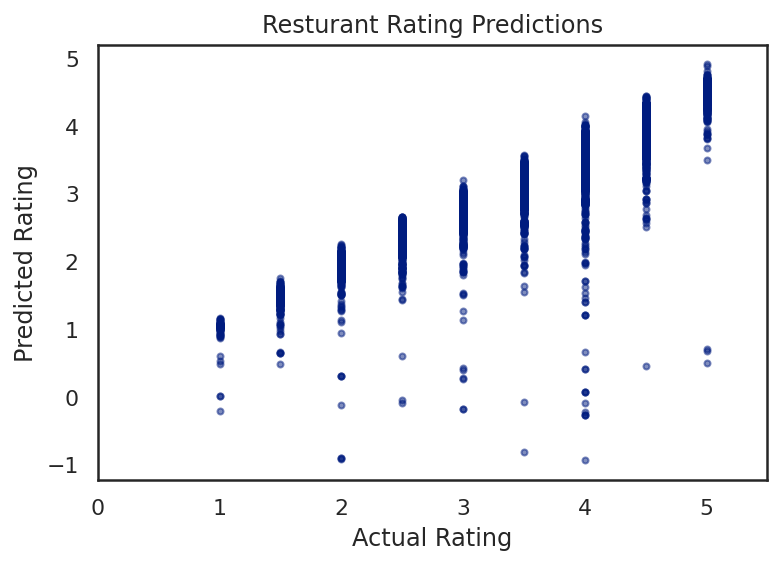

In [78]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = als_pred_best_df.plot('stars','prediction', 
                           marker='o', ls='', ms=3.0,
                           alpha=0.5, legend=False)

_ = ax.set(xlabel='Actual Rating', ylabel='Predicted Rating',
           title='Resturant Rating Predictions')
ax.set_xlim(0, 5.5)

# save the figure in notebooks folder so it's accessible on AWS
fig = plt.gcf()

#fig.savefig('img/restaurant_rating_predictions.pdf')

#Save recommendation model for later use

In [83]:
import requests, os, sys, zipfile, io

model_output_name = 'als_recommendation_model_pipeline_tunned'

# models will not overwrite existing ones of the same name
import shutil
if os.path.exists(model_output_name):
    shutil.rmtree(model_output_name)
    
alsb_model.save(model_output_name)

! ls {model_output_name}

itemFactors  metadata  userFactors


In [84]:
from pyspark.ml.recommendation import ALSModel

reloaded_model = ALSModel.load(model_output_name)
reloaded_model

ALSModel: uid=ALS_ae038f00fc67, rank=20